In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import pickle
import math
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn import metrics
from scipy import stats as stats
from google.colab import files
from sklearn.model_selection import KFold
import warnings
import gc
%matplotlib inline 

In [ ]:
###dataset loading:
# names = ['FUBrain', 'RenClear', 'FreeSolv', 'MicroClear', 'HemoTox', 'HepClear', 'Caco2', 'Sol', 'VDss', 'HalfLifeMWAdjusted']
name = 'MicroClear'
dataframe = pd.read_csv("{}.csv".format(name))

# process data
mols = [Chem.MolFromSmiles(s) for s in dataframe.SMILES]
fps = [np.array(AllChem.GetMorganFingerprintAsBitVect(m,2)) for m in mols]
dataframe["Molecule"] = mols
dataframe["Fingerprint"] = fps

data = pd.DataFrame(data={'Fingerprint': list(np.array(fps).astype(bool)), 'Y':  dataframe.Y.to_numpy()})
del dataframe

# Model Loading
from lightgbm import LGBMRegressor as lgb
model = lgb(subsample=0.1, subsample_freq = 1)

In [ ]:
# Dataframe to store the results
delta = pd.DataFrame(columns=['Pearson\'s r', 'MAE', 'RMSE'])

for iter in range(5):

  # Set up for cross validation
  cv = KFold(n_splits=10, random_state=iter, shuffle=True)

  # use garbage collection to save on space
  gc.collect()
  warnings.filterwarnings(action='once')

  # Cross validation training of the model
  preds = []
  trues = []
  cnt = 0.0
  for train_index, test_index in cv.split(data):
    cnt += 1
    train_df = data[data.index.isin(train_index)]
    test_df = data[data.index.isin(test_index)]

    pair_subset_train = pd.merge(train_df, train_df, how='cross')
    pair_subset_train["Fingerprint"] =  pair_subset_train.Fingerprint_x.combine(pair_subset_train.Fingerprint_y, np.append) # concatenate ExplicitBitVec objects from RDKIT
    pair_subset_train["Delta"] = pair_subset_train.Y_x - pair_subset_train.Y_y # calculate Delta values
    pair_subset_train.drop(['Fingerprint_x','Fingerprint_y','Y_x','Y_y'], axis=1, inplace=True)

    pair_subset_test = pd.merge(test_df, test_df, how='cross')
    pair_subset_test["Fingerprint"] =  pair_subset_test.Fingerprint_x.combine(pair_subset_test.Fingerprint_y, np.append) # concatenate ExplicitBitVec objects from RDKIT
    pair_subset_test["Delta"] = pair_subset_test.Y_x - pair_subset_test.Y_y # calculate Delta values
    pair_subset_test.drop(['Fingerprint_x','Fingerprint_y','Y_x','Y_y'], axis=1, inplace=True)

    model.fit(np.vstack(pair_subset_train.Fingerprint.to_numpy()),pair_subset_train.Delta) # fit model on pair training data
    del pair_subset_train
    preds += [model.predict(np.vstack(pair_subset_test.Fingerprint.to_numpy()))] #predict 
    trues += [pair_subset_test.Delta]
    del pair_subset_test
    print(" Finished " + str(cnt / 10 * 100) + "% of round " + str(iter) )
      

  # Export the csv from cross validation
  # list of name, degree, score
  Trues = np.concatenate(trues)
  Preds = np.concatenate(preds)
  # dictionary of lists 
  dict = {'trues': Trues, 'preds': Preds}     
  dataframe = pd.DataFrame(dict)
  # export
  dataframe.to_csv('{}_CV_LGBM_Delta_{}.csv'.format(name, iter), index = False)
  files.download("{}_CV_LGBM_Delta_{}.csv".format(name, iter))    

  # Calculate Stats
  pearson = stats.pearsonr(Trues, Preds)
  MAE = metrics.mean_absolute_error(Trues, Preds)
  RMSE = math.sqrt(metrics.mean_squared_error(Trues, Preds))
  scoring = pd.DataFrame({'Pearson\'s r': [round(pearson[0], 4)], 'MAE': [round(MAE, 4)], 'RMSE': [round(RMSE, 4)]})
  delta = delta.append(scoring)

# Calculate overall stats
average = pd.DataFrame({'Pearson\'s r': [round(np.mean(delta['Pearson\'s r']), 3)], 'MAE': [round(np.mean(delta['MAE']), 3)], 'RMSE': [round(np.mean(delta['RMSE']), 3)]})
std = pd.DataFrame({'Pearson\'s r': [round(np.std(delta['Pearson\'s r']), 3)], 'MAE': [round(np.std(delta['MAE']), 3)], 'RMSE': [round(np.std(delta['RMSE']), 3)]})
delta = delta.append(average)
delta = delta.append(std)
delta = delta.set_index([pd.Index([1, 2, 3, 4, 5, 'Avg', 'Std. Dev.'])])
delta.to_csv("{}_CV_LGBM_Delta_Scoring.csv".format(name))
files.download("{}_CV_LGBM_Delta_Scoring.csv".format(name))


 Finished 10.0% of round 0
 Finished 20.0% of round 0
 Finished 30.0% of round 0
 Finished 40.0% of round 0
 Finished 50.0% of round 0
 Finished 60.0% of round 0
 Finished 70.0% of round 0
 Finished 80.0% of round 0
 Finished 90.0% of round 0
 Finished 100.0% of round 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Finished 10.0% of round 1
 Finished 20.0% of round 1
 Finished 30.0% of round 1
 Finished 40.0% of round 1
 Finished 50.0% of round 1
 Finished 60.0% of round 1
 Finished 70.0% of round 1
 Finished 80.0% of round 1
 Finished 90.0% of round 1
 Finished 100.0% of round 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Finished 10.0% of round 2
 Finished 20.0% of round 2
 Finished 30.0% of round 2
 Finished 40.0% of round 2
 Finished 50.0% of round 2
 Finished 60.0% of round 2
 Finished 70.0% of round 2
 Finished 80.0% of round 2
 Finished 90.0% of round 2
 Finished 100.0% of round 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Finished 10.0% of round 3
 Finished 20.0% of round 3
 Finished 30.0% of round 3
 Finished 40.0% of round 3
 Finished 50.0% of round 3
 Finished 60.0% of round 3
 Finished 70.0% of round 3
 Finished 80.0% of round 3
 Finished 90.0% of round 3
 Finished 100.0% of round 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Finished 10.0% of round 4
 Finished 20.0% of round 4
 Finished 30.0% of round 4
 Finished 40.0% of round 4
 Finished 50.0% of round 4
 Finished 60.0% of round 4
 Finished 70.0% of round 4
 Finished 80.0% of round 4
 Finished 90.0% of round 4
 Finished 100.0% of round 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

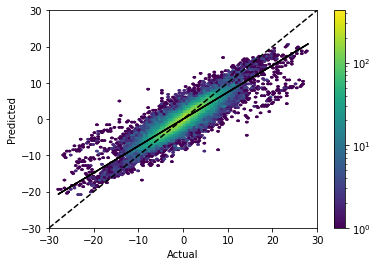

In [ ]:
fig, ax = plt.subplots()

ax.hexbin(np.concatenate(trues), np.concatenate(preds), gridsize=(100),
                norm=matplotlib.colors.LogNorm(), mincnt=1)
fig.colorbar(ax.hexbin(np.concatenate(trues), np.concatenate(preds), gridsize=(100),
                norm=matplotlib.colors.LogNorm(), mincnt=1))

#line of best fit
a, b = np.polyfit(np.concatenate(trues), np.concatenate(preds), 1)
plt.plot(np.concatenate(trues), a*np.concatenate(trues)+b, 'k')


i = 30
# X=Y line on the plot
ax.plot([-i, i], [-i, i], 'k--')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([-i, i])
ax.set_ylim([-i, i])
fig.show()


In [ ]:
pearson = stats.pearsonr(np.concatenate(trues), np.concatenate(preds))
MAE = metrics.mean_absolute_error(np.concatenate(trues),np.concatenate(preds))
RMSE = math.sqrt(metrics.mean_squared_error(np.concatenate(trues), np.concatenate(preds)))

scoring = pd.DataFrame({'Metric': ['Pearson\'s r', 'MAE', 'RMSE'], 'Value': [round(pearson[0], 3), round(MAE, 3), round(RMSE, 3)]})
scoring


,Metric,Value
0,Pearson's r,0.896
1,MAE,1.690
2,RMSE,2.442


In [ ]:
#Train model on the entire dataset
full_data = pd.merge(data, data, how='cross')
full_data["Fingerprint"] =  full_data.Fingerprint_x.combine(full_data.Fingerprint_y, np.append) # concatenate ExplicitBitVec objects from RDKIT
full_data["Delta"] = full_data.Y_x - full_data.Y_y # calculate Delta values
full_data.drop(['Fingerprint_x','Fingerprint_y','Y_x','Y_y'], axis=1, inplace=True)
model.fit(np.vstack(full_data.Fingerprint.to_numpy()),full_data.Delta) 

# Save the model to be referenced later
filename = 'LGBM_delta_{}.sav'.format(name)
pickle.dump(model, open(filename, 'wb'))